In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
https://www.kaggle.com/code
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


In [2]:
# peek data directory
!ls  -ltr ../input/titanic

total 92
-rw-r--r-- 1 nobody nogroup 61194 Nov 17 22:50 train.csv
-rw-r--r-- 1 nobody nogroup 28629 Nov 17 22:50 test.csv
-rw-r--r-- 1 nobody nogroup  3258 Nov 17 22:50 gender_submission.csv


In [3]:
train = pd.read_csv("../input/titanic/train.csv")
test = pd.read_csv("../input/titanic/test.csv")

In [4]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
# check missing values in both train and test sets
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [6]:
test.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

## Missing Values

In [7]:
def process_nan(df):
    # fillna with mean of 'Fare'
    df["Fare"] = df["Fare"].fillna(df["Fare"].mean())
    # fillna with mode of 'Embarked'
    df["Embarked"] = df["Embarked"].fillna("S")
    # fillna into the missing category.
    df["Age"] = df["Age"].fillna(-0.5)
    cut_points = [-1,0,5,12,18,35,60,100]
    label_names = ["Missing","Infant","Child","Teenager","Young Adult","Adult","Senior"]
    df["Age_categories"] = pd.cut(df["Age"],cut_points,labels=label_names)
    # introduce new feature 'cabin_type' and fillna as 'uknonwn'
    df["Cabin_type"] = df["Cabin"].str[0]
    df["Cabin_type"] = df["Cabin_type"].fillna("Unknown")
    df = df.drop('Cabin',axis=1)
    return df

In [8]:
train_clean = process_nan(train)

In [9]:
# whatever we do to the train set, will need to also do for the test set
test_clean = process_nan(test)

In [10]:
test_clean.isnull().sum()

PassengerId       0
Pclass            0
Name              0
Sex               0
Age               0
SibSp             0
Parch             0
Ticket            0
Fare              0
Embarked          0
Age_categories    0
Cabin_type        0
dtype: int64

In [11]:
train_clean.isnull().sum()

PassengerId       0
Survived          0
Pclass            0
Name              0
Sex               0
Age               0
SibSp             0
Parch             0
Ticket            0
Fare              0
Embarked          0
Age_categories    0
Cabin_type        0
dtype: int64

Great, no more missing values. Next, we will do further preprocessing, concretely fequency binning for features that are more analog in natures. Only 'Fare' is remaining, we had already binned 'age' above.

In [12]:
cut_points = [-1,12,50,100,1000]
label_names = ["0-12","12-50","50-100","100+"]
train_clean["Fare_categories"] = pd.cut(train_clean["Fare"],cut_points,labels=label_names)
test_clean["Fare_categories"] = pd.cut(test_clean["Fare"],cut_points,labels=label_names)

## Further Preprocessing
* We will need to deal with string features.
* 'Name', 'Sex' and 'Ticket'
* We will also need to one hot encode all binned string categories as well for model digestion. 'Age_categories', 'Fare_categories', 'Title', 'Cabin_type', 'Sex'.

In [13]:
# function to extract title from name
def process_titles(df):
    """Extract and categorize the title from the name column 
    Usage
    ------
    train = process_titles(train)
    """
    titles = {
        "Mr" :         "Mr",
        "Mme":         "Mrs",
        "Ms":          "Mrs",
        "Mrs" :        "Mrs",
        "Master" :     "Master",
        "Mlle":        "Miss",
        "Miss" :       "Miss",
        "Capt":        "Officer",
        "Col":         "Officer",
        "Major":       "Officer",
        "Dr":          "Officer",
        "Rev":         "Officer",
        "Jonkheer":    "Royalty",
        "Don":         "Royalty",
        "Sir" :        "Royalty",
        "Countess":    "Royalty",
        "Dona":        "Royalty",
        "Lady" :       "Royalty"
    }
    extracted_titles = df["Name"].str.extract(' ([A-Za-z]+)\.',expand=False)
    df["Title"] = extracted_titles.map(titles)
    # import pdb; pdb.set_trace()
    return df

In [14]:
train_clean = process_titles(train_clean)
test_clean = process_titles(test_clean)

In [15]:
train_clean.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Age_categories,Cabin_type,Fare_categories,Title
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S,Young Adult,Unknown,0-12,Mr
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,Adult,C,50-100,Mrs
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S,Young Adult,Unknown,0-12,Miss
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S,Young Adult,C,50-100,Mrs
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S,Young Adult,Unknown,0-12,Mr


In [16]:
feature_to_ohe = ["Age_categories","Fare_categories","Title","Cabin_type","Sex"]

In [17]:
# one hot encode train set
for feature in feature_to_ohe:
    dummies = pd.get_dummies(train_clean[feature],prefix=feature)
    train_clean = pd.concat([train_clean, dummies], axis=1)

In [18]:
# one hot encode test set
for feature in feature_to_ohe:
    dummies = pd.get_dummies(test_clean[feature],prefix=feature)
    test_clean = pd.concat([test_clean, dummies], axis=1)

## Exploratory Data Analysis
* Look for correlations between survivors and several features (bivariate analysis), i.e. suspect feature with that of hte label.
* Create new features depending on what we find.

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

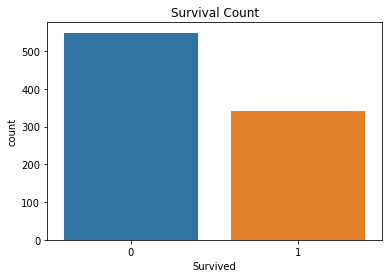

0    549
1    342
Name: Survived, dtype: int64

In [41]:
axes = sns.countplot(x='Survived', data=train_clean, orient='h')
plt.title('Survival Count')
plt.show()
train_clean['Survived'].value_counts()

Slightly unbalance target, we will see if we will need to perform some sampling techniques to combat this, i.e. under or over sampling, as well as, algorithmic techniques to better performance.

In [40]:
train_clean['Sex'].value_counts()

male      577
female    314
Name: Sex, dtype: int64

In [57]:
def eda_bivariate_plot(df, features):
    fig, saxis = plt.subplots(1, len(features),figsize=(len(features) * 10,10))
    for idx, feature in enumerate(features):
        sns.barplot(feature, y="Survived", data=df, ax=saxis[idx])
    plt.show()

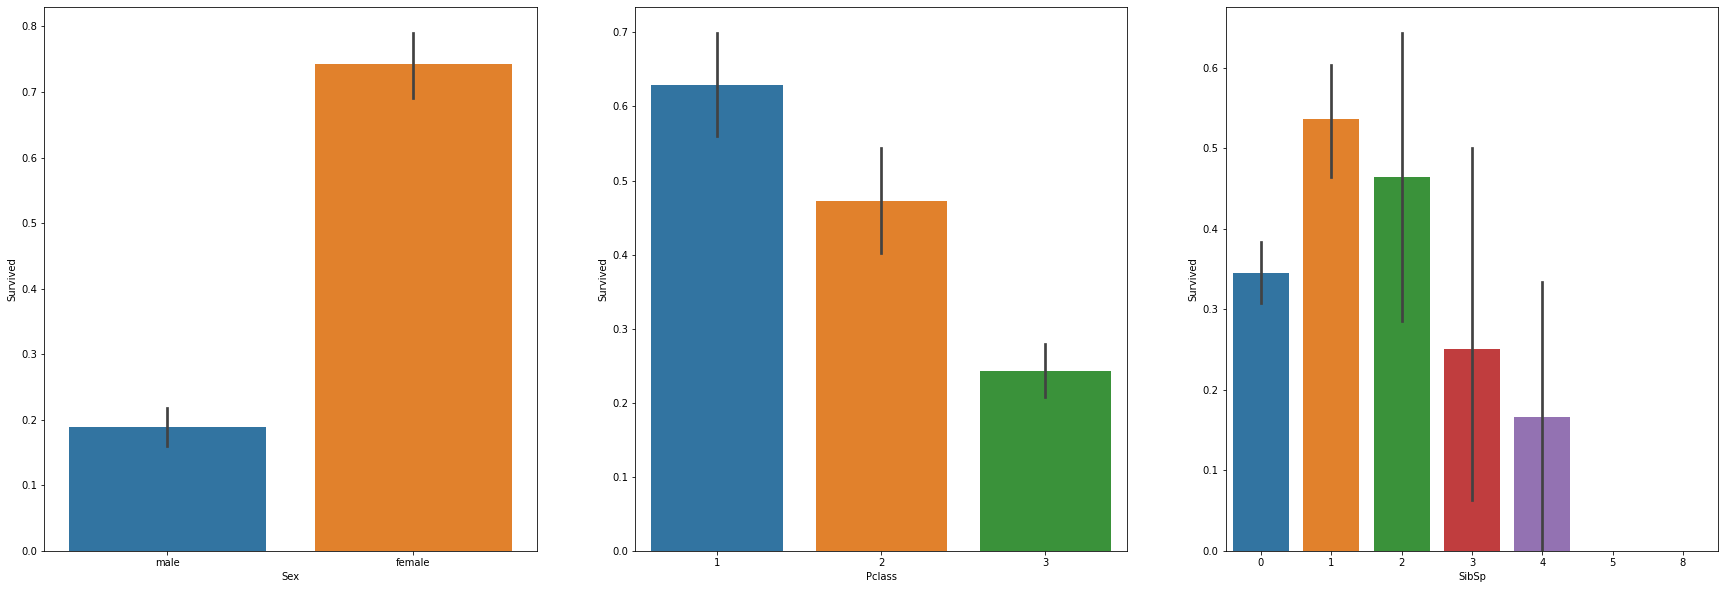

In [61]:
# Ignore Warnings
import warnings
warnings.filterwarnings('ignore')
# features we think that may have a direct correlation with target 'Survived'
f1 = ['Sex', 'Pclass', 'SibSp']
f2 = ['Parch', 'Embarked', 'Age_categories']
eda_bivariate_plot(train_clean, f1)

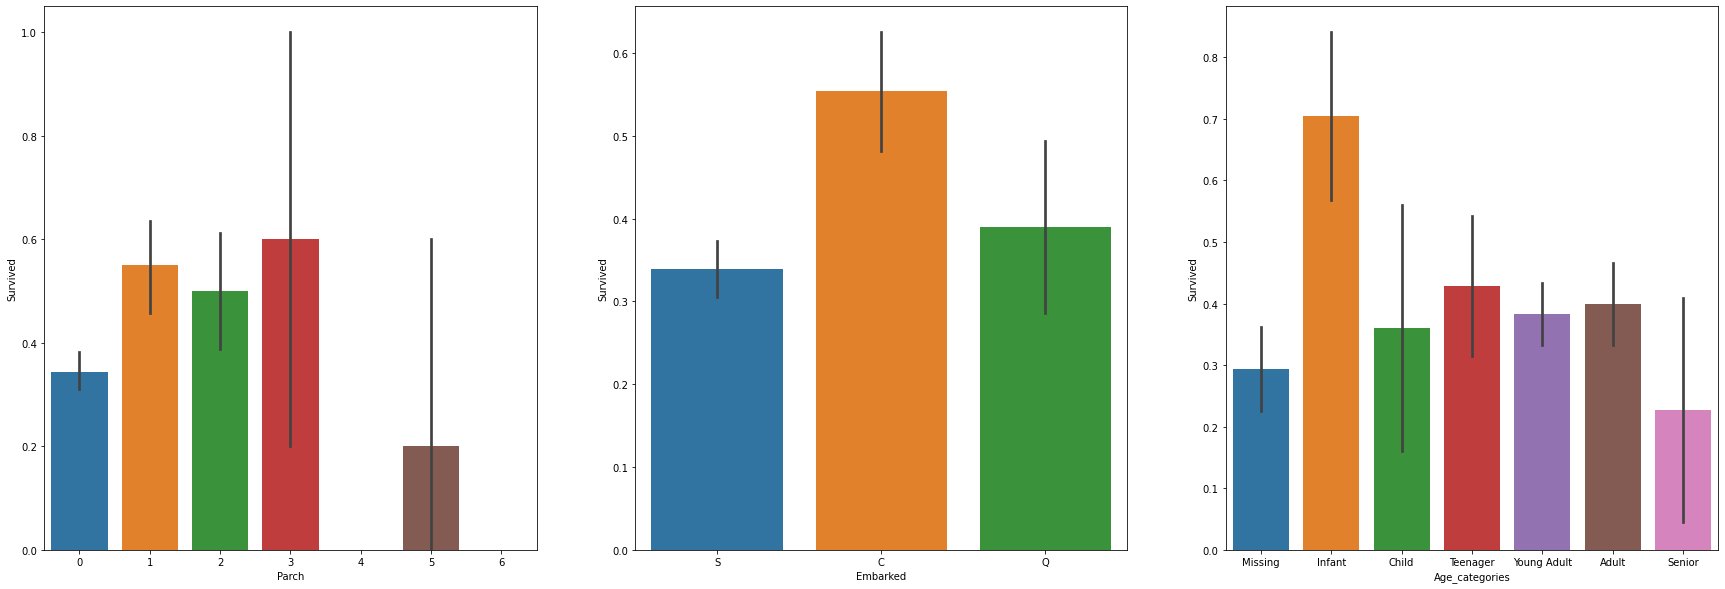

In [62]:
eda_bivariate_plot(train_clean, f2)

## Keytakeaways
* More females had survived than men. Makes sense, men most likely gave their spot to females on lifeboats.
* Ticket class 1, perhaps those who paid hire for their tickets belong to high socioeconomic class and hence had higher chance of reserving a spot on the lifeboats.
* If one had a sibling, chances of survival is a lot higher. Makes sense, families most likely prioritized on lifeboats.
* Parents + children also had higher chance of survival.
* 'Embarked' class C had a higher chance of surivival - high socioeconomic reasons?
* Per age groups, children had higher survival rate with Seniors with the lowest rate.

In [67]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Age_categories,Cabin_type
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Young Adult,Unknown
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Adult,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Young Adult,Unknown
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Young Adult,C
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Young Adult,Unknown


## Feature Engineering
* Add another feature for family size
* Flag feature for if passenger is alone.

In [75]:
# from the above Bivariate EDA, it appears that families tend to have a higher chance of survival.
def process_family(df):
    df['family_size'] = df[['SibSp', 'Parch']].sum(axis=1)
    return df

train_clean = process_family(train_clean)
test_clean = process_family(test_clean)

In [79]:
train_clean['family_size'].value_counts() # from stdout, looks like lots of people without families

0     537
1     161
2     102
3      29
5      22
4      15
6      12
10      7
7       6
Name: family_size, dtype: int64

In [82]:
def is_alone(size):
    if size < 1:
        return 1
    return 0

train_clean['alone'] = train_clean['family_size'].apply(is_alone)
test_clean['alone'] = test_clean['family_size'].apply(is_alone)

In [83]:
train_clean['alone'].value_counts()

1    537
0    354
Name: alone, dtype: int64

## Feature Selection
* Create def to process df and output best features.
* Use sklearn's recursive feature elimination in conjuntion with RandomForestClassifier (better for overfitting)

In [86]:
feature_cols = train_clean.columns
train_clean.dtypes

PassengerId                      int64
Survived                         int64
Pclass                           int64
Name                            object
Sex                             object
Age                            float64
SibSp                            int64
Parch                            int64
Ticket                          object
Fare                           float64
Embarked                        object
Age_categories                category
Cabin_type                      object
Fare_categories               category
Title                           object
Age_categories_Missing           uint8
Age_categories_Infant            uint8
Age_categories_Child             uint8
Age_categories_Teenager          uint8
Age_categories_Young Adult       uint8
Age_categories_Adult             uint8
Age_categories_Senior            uint8
Fare_categories_0-12             uint8
Fare_categories_12-50            uint8
Fare_categories_50-100           uint8
Fare_categories_100+     

In [88]:
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier

numeric_dtypes = ['uint8', 'int64']
def select_features(df):
    cols = df.columns
    # remove any non-numeric cols - data preparation before feeding to estimator. Quick clean way to drop...
    for col in cols:
        if df[col].dtype not in numeric_dtypes:
            df = df.drop(col, axis=1)
    
    y = df['Survived']
    # also drop 'PassengerId' and 'target' from X_train.
    X = df.drop(['PassengerId', 'Survived'], axis=1)
    clf = RandomForestClassifier(n_estimators=10)
    selector = RFECV(clf, step=1, cv=10)
    selector = selector.fit(X, y)
    # pdb.set_trace()
    best_columns = list(X.columns[selector.support_])
    print("Best Columns \n"+"-"*12+"\n{}\n".format(best_columns))
    return best_columns

In [95]:
filtered_cols_train = select_features(train_clean)

Best Columns 
------------
['Pclass', 'SibSp', 'Parch', 'Age_categories_Missing', 'Age_categories_Infant', 'Age_categories_Teenager', 'Age_categories_Young Adult', 'Age_categories_Adult', 'Fare_categories_0-12', 'Fare_categories_12-50', 'Fare_categories_50-100', 'Fare_categories_100+', 'Title_Master', 'Title_Mr', 'Title_Mrs', 'Cabin_type_B', 'Cabin_type_C', 'Cabin_type_D', 'Cabin_type_E', 'Cabin_type_Unknown', 'Sex_female', 'Sex_male', 'family_size', 'alone']



## Select Model and fine-tuning of Hyperparameters

In [92]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.model_selection import GridSearchCV

def select_model(df,features):
    
    all_X = df[features]
    all_y = df["Survived"]

    # List of dictionaries, each containing a model name,
    # it's estimator and a dict of hyperparameters
    models = [
        {
            "name": "LogisticRegression",
            "estimator": LogisticRegression(),
            "hyperparameters":
                {
                    "solver": ["newton-cg", "lbfgs", "liblinear"]
                }
        },
        {
            "name": "KNeighborsClassifier",
            "estimator": KNeighborsClassifier(),
            "hyperparameters":
                {
                    "n_neighbors": range(1,20,2),
                    "weights": ["distance", "uniform"],
                    "algorithm": ["ball_tree", "kd_tree", "brute"],
                    "p": [1,2]
                }
        },
        {
            "name": "AdaBoostClassifier",
            "estimator": AdaBoostClassifier(random_state=1),
            "hyperparameters":
                {
                    "n_estimators": [10, 25,50]
                }
        },
        {
            "name": "RandomForestClassifier",
            "estimator": RandomForestClassifier(random_state=1),
            "hyperparameters":
                {
                    "n_estimators": [10, 15, 20],
                    "criterion": ["entropy", "gini"],
                    "max_depth": [2, 5, 10],
                    "max_features": ["log2", "sqrt"],
                    "min_samples_leaf": [1, 5, 8],
                    "min_samples_split": [2, 3, 5]

                }
        }
    ]

    for model in models:
        print(model['name'])
        print('-'*len(model['name']))

        grid = GridSearchCV(model["estimator"],
                            param_grid=model["hyperparameters"],
                            cv=10)
        grid.fit(all_X,all_y)
        model["best_params"] = grid.best_params_
        model["best_score"] = grid.best_score_
        model["best_model"] = grid.best_estimator_

        print("Best Score: {}".format(model["best_score"]))
        print("Best Parameters: {}\n".format(model["best_params"]))

    return models

In [96]:
res = select_model(train_clean,filtered_cols_train)

LogisticRegression
------------------
Best Score: 0.8215980024968788
Best Parameters: {'solver': 'liblinear'}

KNeighborsClassifier
--------------------
Best Score: 0.8216104868913858
Best Parameters: {'algorithm': 'ball_tree', 'n_neighbors': 17, 'p': 1, 'weights': 'uniform'}

AdaBoostClassifier
------------------
Best Score: 0.8137203495630461
Best Parameters: {'n_estimators': 10}

RandomForestClassifier
----------------------
Best Score: 0.8305742821473159
Best Parameters: {'criterion': 'entropy', 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 20}



In [98]:
res[3] # best model is RFC

{'name': 'RandomForestClassifier',
 'estimator': RandomForestClassifier(random_state=1),
 'hyperparameters': {'n_estimators': [10, 15, 20],
  'criterion': ['entropy', 'gini'],
  'max_depth': [2, 5, 10],
  'max_features': ['log2', 'sqrt'],
  'min_samples_leaf': [1, 5, 8],
  'min_samples_split': [2, 3, 5]},
 'best_params': {'criterion': 'entropy',
  'max_depth': 10,
  'max_features': 'log2',
  'min_samples_leaf': 1,
  'min_samples_split': 2,
  'n_estimators': 20},
 'best_score': 0.8305742821473159,
 'best_model': RandomForestClassifier(criterion='entropy', max_depth=10, max_features='log2',
                        n_estimators=20, random_state=1)}

In [100]:
def save_submission_file(model,cols,filename="submission.csv"):
    holdout_data = test_clean[cols]
    predictions = model.predict(holdout_data)
    
    holdout_ids = test_clean["PassengerId"]
    submission_df = {"PassengerId": holdout_ids,
                 "Survived": predictions}
    submission = pd.DataFrame(submission_df)

    submission.to_csv(os.path.join('/kaggle/working',filename),index=False)
    return submission
# from above results, feed in idx 2, which is your best model and re-eval on holdout 
# set for submission
best_rf_model = res[3]["best_model"]
print(f'Best model: {best_rf_model}')
df_submission = save_submission_file(best_rf_model,filtered_cols_train)

Best model: RandomForestClassifier(criterion='entropy', max_depth=10, max_features='log2',
                       n_estimators=20, random_state=1)


In [ ]:
! ls